<div style="margin: 0 auto; padding: 20px; font-family: 'Helvetica', sans-serif; font-size: 16px;">

## Data Processing Workflow

In this workflow within PyCCAPT, we can crope the data, do the voltage and bowl calibration, calculate the 3d reconstruction, and do the ranging.
</div>

In [1]:
# Activate intractive functionality of matplotlib
%matplotlib ipympl
# Activate auto reload 
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
# import libraries
import os
import numpy as np
from ipywidgets import widgets
from IPython.display import display
from ipywidgets import fixed, interact_manual
import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

# Local module and scripts
from pyccapt.calibration.calibration_tools import widgets as wd
from pyccapt.calibration.data_tools import data_tools, data_loadcrop, dataset_path_qt
from pyccapt.calibration.tutorials.tutorials_helpers import helper_calibration
from pyccapt.calibration.tutorials.tutorials_helpers import helper_data_loader
from pyccapt.calibration.tutorials.tutorials_helpers import helper_temporal_crop
from pyccapt.calibration.tutorials.tutorials_helpers import helper_special_crop
from pyccapt.calibration.tutorials.tutorials_helpers import helper_t_0_tune
from pyccapt.calibration.tutorials.tutorials_helpers import helper_mc_plot
from pyccapt.calibration.tutorials.tutorials_helpers import helper_3d_reconstruction
from pyccapt.calibration.tutorials.tutorials_helpers import helper_ion_selection
from pyccapt.calibration.tutorials.tutorials_helpers import helper_visualization
from pyccapt.calibration.tutorials.tutorials_helpers import helper_ion_list

<div style="margin: 0 auto; padding: 20px; font-family: 'Helvetica', sans-serif; font-size: 16px;">
In case of recieving the error about pytable library, you have to install the pytables library with conda command. to do that you can open a new cell and copy the line below in it. Then just run it like other cells. The pytables library will be innstalled.
    
`!conda install --yes --prefix {sys.prefix} pytables`
</div>


<div style="margin: 0 auto; padding: 20px; font-family: 'Helvetica', sans-serif; font-size: 16px;">
    
By clicking on the button below, you can select the dataset file you want to crop. The dataset file can be in various formats, including HDF5, EPOS, POS, ATO, and CSV. The cropped data will be saved in the same directory as the original dataset file in a new directory nammed load_crop. The name of the cropped dataset file will be the same as the original dataset file. The figures will be saved in the same directory as the dataset file.
</div>

In [9]:
button = widgets.Button(
    description='load dataset',
)
@button.on_click
def open_file_on_click(b):
    """
    Event handler for button click event.
    Prompts the user to select a dataset file and stores the selected file path in the global variable dataset_path.
    """
    global dataset_path
    dataset_path = dataset_path_qt.gui_fname().decode('ASCII')
button

Button(description='load dataset', style=ButtonStyle())

<div style="margin: 0 auto; padding: 20px; font-family: 'Helvetica', sans-serif; font-size: 16px;">

## ROI Selection and Data Cropping
    

</div>



<div style="margin: 0 auto; padding: 20px; font-family: 'Helvetica', sans-serif; font-size: 16px;">

    
From the dropdown lists below, you can select the instrument specifications of the dataset. The instrument specifications are the same as the ones used for the calibration process. Data mode is specify the dataset structure. The dataset can be in raw or calibrated mode. The flight path length is the distance between the sample and the detector. The t0 is the time of flight of the ions with the lowest mass-to-charge ratio. The maximum mass-to-charge ratio is the maximum mass-to-charge ratio of tat you want to plot. You can also change it in te related cells. The detector diameter is the diameter of the detector.
</div>


In [16]:
# create an object for selection of instrument specifications of the dataset
tdc, pulse_mode, flight_path_length, t0, max_mc, det_diam = wd.dataset_instrument_specification_selection()

# Display lists and comboboxes to selected instrument specifications
display(tdc, pulse_mode, flight_path_length, t0, max_mc)

Dropdown(description='Data mode:', options=('pyccapt', 'leap_epos', 'leap_pos', 'ato_v6'), value='pyccapt')

Dropdown(description='Pulse mode:', options=('voltage', 'laser'), value='voltage')

FloatText(value=110.0, description='Flight path length:')

FloatText(value=38.0, description='t0:')

FloatText(value=400.0, description='Max mc:')

In [17]:
variables = helper_data_loader.load_data(dataset_path, max_mc.value, flight_path_length.value, pulse_mode.value, tdc.value)
display(variables.data)
display(variables.range_data)

The maximum possible TOF is: 5010 ns
The data will be saved on the path: T:/Monajem/Ortner/Epos_Crystal_recon/R56_05538-v03/data_processing/
The dataset name after saving is: R56_05538-v03
The figures will be saved on the path: T:/Monajem/Ortner/Epos_Crystal_recon/R56_05538-v03/data_processing/
Total number of Ions: 29500316


,x (nm),y (nm),z (nm),mc_c (Da),mc (Da),high_voltage (V),pulse,start_counter,t_c (ns),t (ns),x_det (cm),y_det (cm),pulse_pi,ion_pp
0,-0.797289,0.189189,0.005577,26.970173,0.0,4079.629883,815.925964,0,0.0,1873.781982,-1.096098,0.266187,0,1
1,1.616762,8.717011,0.656416,26.966919,0.0,4079.629883,815.925964,0,0.0,1875.974365,0.855491,6.228777,314,1
2,-10.108647,-0.503136,0.856949,26.979609,0.0,4079.629883,815.925964,0,0.0,1853.190918,-7.298410,-0.212950,5,1
3,2.763345,16.409430,2.345595,13.495921,0.0,4079.629883,815.925964,0,0.0,1324.285645,2.352601,11.685612,58,1
4,-15.475331,-1.666233,2.047008,27.018654,0.0,4079.629883,815.925964,0,0.0,1841.099609,-10.613440,-1.064748,110,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29500311,-15.779431,-8.005019,335.378479,27.319469,0.0,8289.629883,1657.926025,0,0.0,1310.368652,-5.774566,-2.635252,0,0
29500312,0.565685,32.896160,338.599609,26.989311,0.0,8289.629883,1657.926025,0,0.0,1309.762573,0.534682,11.499281,135,1
29500313,15.861534,18.763754,336.584900,26.983139,0.0,8289.629883,1657.926025,0,0.0,1321.584473,5.507226,6.654676,19,1
29500314,-21.867247,-26.479500,339.011414,13.547936,0.0,8289.629883,1657.926025,0,0.0,917.004272,-7.218208,-9.103598,138,1


,ion,mass,mc,mc_low,mc_up,color,element,complex,isotope,charge
0,unranged,0.0,0.0,0.0,400.0,#000000,unranged,0,0,0


In [5]:
#load data, if it exists,
try:
    if os.path.exists(variables.result_data_path + '//' + variables.result_data_name + '.h5'):
        variables.data = data_tools.load_data(variables.result_data_path + '//' + variables.result_data_name + '.h5', tdc='pyccapt', mode='processed')
        # exctract needed data from Pandas data frame as an numpy array
        data_tools.extract_data(variables.data, variables, flight_path_length.value, max_mc.value)
        print('Load data successfully')
    elif os.path.exists(variables.result_data_path + '//' + variables.result_data_name + 'temp' + '.h5'):
        variables.data = data_tools.load_data(variables.result_data_path + '//' + variables.result_data_name + '.h5', tdc='pyccapt', mode='processed')
        # exctract needed data from Pandas data frame as an numpy array
        data_tools.extract_data(variables.data, variables, flight_path_length.value, max_mc.value)
        print('Continue from the point based on the loaded data')
        
    else:
        print('No data avaliable')
    if os.path.exists(variables.result_data_path + '/' + 'range_' + variables.dataset_name+ '.h5'):
        variables.range_data = data_tools.read_hdf5_through_pandas(variables.result_data_path + '/' + 'range_' + variables.dataset_name+ '.h5')
        # exctract needed data from Pandas data frame as an numpy array
        data_tools.extract_data(variables.data, variables, flight_path_length.value, max_mc.value)
        print('Load range file')
    else:
        print('No range data avaliable')
    # exctract needed data from Pandas data frame as a numpy array
    data_tools.extract_data(variables.data, variables, flight_path_length.value, max_mc.value)
    display(variables.data)
    display(variables.range_data)
except Exception as e:
    pass
    # print(e)

The maximum time of flight: 5010
Load data successfully
The maximum time of flight: 5010
Load range file
The maximum time of flight: 5010


,x (nm),y (nm),z (nm),mc_c (Da),mc (Da),high_voltage (V),pulse,start_counter,t_c (ns),t (ns),x_det (cm),y_det (cm),pulse_pi,ion_pp
0,0.0,0.0,0.0,0.0,29.662619,4994.750000,998.950012,4583,0.0,618.200684,-1.479184,-1.802449,0,0
1,0.0,0.0,0.0,0.0,29.079235,4994.750000,998.950012,4641,0.0,611.109497,1.456326,-1.648980,58,2
2,0.0,0.0,0.0,0.0,14.561744,4994.750000,998.950012,4897,0.0,440.791107,1.031837,-1.436735,256,1
3,0.0,0.0,0.0,0.0,29.420926,4994.750000,998.950012,5312,0.0,608.311462,1.204898,-0.845714,415,1
4,0.0,0.0,0.0,0.0,29.190067,4994.750000,998.950012,5386,0.0,608.023438,1.482449,-0.904490,74,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10343681,0.0,0.0,0.0,0.0,30.230337,6353.089844,1270.618042,9874,0.0,560.504333,-2.618776,-0.346122,43,1
10343682,0.0,0.0,0.0,0.0,30.793319,6353.089844,1270.618042,9876,0.0,557.301636,-1.560816,0.816327,2,1
10343683,0.0,0.0,0.0,0.0,30.173875,6353.089844,1270.618042,9998,0.0,558.522400,-1.492245,2.004898,122,1
10343684,0.0,0.0,0.0,0.0,15.065464,6353.089844,1270.618042,10068,0.0,405.403809,-2.024490,-1.368163,70,1


,ion,mass,mc,mc_low,mc_up,color,element,complex,isotope,charge
0,${}^{1}H^{+}$,1.01,1.002565,0.837600,1.144211,#6bd912,[H],[1],[1],1
1,${}^{27}Al^{2+}$,13.49,13.433510,13.293074,14.274230,#f25f75,[Al],[1],[27],2
2,${}^{27}Al^{+}$,26.98,26.967200,26.225805,28.703226,#f80d30,[Al],[1],[27],1


<div style="margin: 0 auto; padding: 20px;">

# Temporal crop

Select the data by drawing a rectangle over the experiment history. Experiment history is a 2D histogram of the time of flight of the ions versus sequence of evaporation. The experiment history is plotted by clicking on the button below te cell.
</div>


In [ ]:
helper_temporal_crop.call_plot_crop_experiment(variables, pulse_mode.value)

<div style="margin: 0 auto; padding: 20px; font-family: 'Helvetica', sans-serif; font-size: 16px;">

# Spacial crop

Select the region of maximum concentration of Ions in the below plotted graph to utilize relevant data. To crop you can draw a circle over the filed desorption map. The field desorption map is a 2D histogram of the time of flight of the ions versus the position of the ions on the detector. The field desorption map is plotted by clicking on the button below the cell.
</div>

In [ ]:
helper_special_crop.call_plot_crop_fdm(variables)

<div style="margin: 0 auto; padding: 20px; font-family: 'Helvetica', sans-serif; font-size: 16px;">

Calculate pulses since the last event pulse and ions per pulse. The percentage of loss in ROI selection process will be printed.
</div>

In [ ]:
pulse_pi, ion_pp = data_loadcrop.calculate_ppi_and_ipp(variables.data)

# add two calculated array to the croped dataset
variables.data['pulse_pi'] = pulse_pi.astype(np.uintc)
variables.data['ion_pp'] = ion_pp.astype(np.uintc)

# exctract needed data from Pandas data frame as an numpy array
variables.dld_high_voltage = variables.data['high_voltage (V)'].to_numpy()
variables.dld_pulse = variables.data['pulse'].to_numpy()
variables.dld_t = variables.data['t (ns)'].to_numpy()
variables.dld_x_det = variables.data['x_det (cm)'].to_numpy()
variables.dld_y_det = variables.data['y_det (cm)'].to_numpy()

# save the cropped data
print('tof Crop Loss {:.2f} %'.format((100 - (len(variables.data) / len(variables.data)) * 100)))
#percentage of double event per pulse
print('percentage of double event per pulse', len(ion_pp[ion_pp != 1]) / float(len(ion_pp)))

<div style="margin: 0 auto; padding: 20px; font-family: 'Helvetica', sans-serif; font-size: 16px;">

In the next cell by changing the t<sub>0</sub> value you can correct the position of H<sub>1</sub> or any other known peak. this correction would be helpful for the position of the peaks in the m/c calibration process.
</div>

In [ ]:
helper_t_0_tune.call_fine_tune_t_0(variables, flight_path_length, pulse_mode, t0)

<div style="margin: 0 auto; padding: 20px; font-family: 'Helvetica', sans-serif; font-size: 16px;">

Remove the data with m/c greater than max m/c and x, y, t = 0. Also add the needed colums for calibration. The data types of the final cropped dataset is displayed below.

</div>

In [ ]:
# add the columns in the dataset for x, y, z, mc, mc calibrated, and t calibrated
helper_data_loader.add_columns(variables, max_mc)
# save data temporarily
data_tools.save_data(variables.data, variables, hdf=True, epos=False, pos=False, ato_6v=False, csv=False, temp=True)
display(variables.data)
display(variables.data.dtypes)

-------------------------------------------------------
-------------------------------------------------------

<div style="margin: 0 auto; padding: 20px; font-family: 'Helvetica', sans-serif; font-size: 16px;">

## Time-of-Flight/Mass-to-charge Calibration
</div>

<div style="margin: 0 auto; padding: 20px; font-family: 'Helvetica', sans-serif; font-size: 16px;">
    
Below you can plot the ToF histogram of the dataset. You can select the peak range of the data you want to plot by drawing a rectangle over peak with holding left click. After that you should apply the voltage and bowl calibration. These three steps should be repeated until you see no improvement in the peak resolution. You can also save the calibration by clicking on the save button. The saved calibration will be used for the next steps.

</div>

In [6]:
# exctract needed data from Pandas data frame as an numpy array
data_tools.extract_data(variables.data, variables, flight_path_length.value, max_mc.value)
calibration_mode = widgets.Dropdown(
    options=[('time_of_flight', 'tof'), ('mass_to_charge', 'mc')],
    description='calibration mode:')
display(calibration_mode)

The maximum time of flight: 5010


Dropdown(description='calibration mode:', options=(('time_of_flight', 'tof'), ('mass_to_charge', 'mc')), value…

In [27]:
helper_calibration.call_voltage_bowl_calibration(variables, det_diam, calibration_mode)

Output()

In [ ]:
variables.dld_t_calib_backup = np.copy(variables.dld_t_calib)
variables.mc_calib_backup = np.copy(variables.mc_calib)

In [ ]:
helper_ion_list.call_ion_list(variables, selector='peak', calibration_mode=calibration_mode)

In [ ]:
from pyccapt.calibration.mc.tof_tools import mc2tof
mc2tof(1, 4000, 0, 0, 110)

In [ ]:
helper_mc_plot.call_mc_plot(variables, selector='None')

In [ ]:
variables.data['mc_c (Da)'] = variables.mc_calib
variables.data['t_c (ns)'] = variables.dld_t_calib
# Remove negative mc
threshold = 0
mc_t = variables.data['mc_c (Da)'].to_numpy()
mc_t_mask = (mc_t <= threshold)
print('The number of ions with negative mc are:', len(mc_t_mask[mc_t_mask==True]))
variables.data.drop(np.where(mc_t_mask)[0], inplace=True)
variables.data.reset_index(inplace=True, drop=True)
# save data temporarily
data_tools.save_data(variables.data, variables, hdf=True, epos=False, pos=False, ato_6v=False, csv=False, temp=True)

-------------------------------------------------------
-------------------------------------------------------

<div style="margin: 0 auto; padding: 20px; font-family: 'Helvetica', sans-serif; font-size: 16px;">

## 3D Reconstruction
After bowl and voltage calibration we are ready to calculate the 3d reconstruction. In this workflow we calculate the reconstructed x,y,z and then plot the 3d, heatmap, projection plots and mass-to-charge histogram.

</div>

In [ ]:
# exctract needed data from Pandas data frame as an numpy array
data_tools.extract_data(variables.data, variables, flight_path_length.value, max_mc.value)

display(variables.data)

<div style="margin: 0 auto; padding: 20px; font-family: 'Helvetica', sans-serif; font-size: 16px;">

You have to select the main element in your sample from the from dropdown below.
</div>

In [ ]:
element_selected = wd.density_field_selection()
display(element_selected)

<div style="margin: 0 auto; padding: 20px; font-family: 'Helvetica', sans-serif; font-size: 16px;">

In case that yopu face error about plotly library, like javascripts error. You have check your jupyter lab version is compatibale with the plotly extenstion. Sometimes running `jupyter lab build` command fix the proble.
</div>

In [ ]:
helper_3d_reconstruction.call_x_y_z_calculation(variables, flight_path_length, element_selected)

In [ ]:
variables.plotly_3d_reconstruction

In [ ]:
variables.data['x (nm)'] = variables.x
variables.data['y (nm)'] = variables.y
variables.data['z (nm)'] = variables.z
# save data temporarily
data_tools.save_data(variables.data, variables, hdf=True, epos=False, pos=False, ato_6v=False, csv=False, temp=True)

-------------------------------------------------------
-------------------------------------------------------

<div style="margin: 0 auto; padding: 20px; font-family: 'Helvetica', sans-serif; font-size: 16px;">

## Ion Selection and Rangging

This tutorial outlines a comprehensive workflow for ion selection and organization. Users can choose ions using peak and element finders, manually add ions, customize ion colors, and create histograms. Histograms can be generated for selected ranges and areas, and figures can be saved. Additionally, users have the option to save both figures and data in CSV and HDF5 formats.

</div>

In [ ]:
# exctract needed data from Pandas data frame as an numpy array
data_tools.extract_data(variables.data, variables, flight_path_length.value, max_mc.value)

display(variables.data)

In [ ]:
helper_ion_selection.call_ion_selection(variables)

In [ ]:
variables.range_data

In [ ]:
variables.range_data.dtypes

<div style="margin: 0 auto; padding: 20px; font-family: 'Helvetica', sans-serif; font-size: 16px;">

Save the range in the hdf5 and csv format.

</div>

In [ ]:
# save the new data
name_save_file = variables.result_data_path + '/' + 'range_' + variables.dataset_name + '.h5'
data_tools.store_df_to_hdf(variables.range_data,  'df', name_save_file)
# save data in csv format
name_save_file = variables.result_data_path + '/' + 'range_' + variables.dataset_name + '.csv'
data_tools.store_df_to_csv(variables.range_data, name_save_file)

<div style="margin: 0 auto; padding: 20px; font-family: 'Helvetica', sans-serif; font-size: 16px;">

Save the cropped dataset. You can specify te output format from list below. The output formats are HDF5, EPOS, POS, ATO, and CSV. The output file will be saved in the same directory as the original dataset file in a new directory nammed load_crop.
</div>

In [18]:
interact_manual(data_tools.save_data, data=fixed(variables.data), variables=fixed(variables),
                hdf=widgets.Dropdown(options=[('True', True), ('False', False)]),
                epos=widgets.Dropdown(options=[('False', False), ('True', True)]),
                pos=widgets.Dropdown(options=[('False', False), ('True', True)]),
                ato_6v=widgets.Dropdown(options=[('False', False), ('True', True)]),
                csv=widgets.Dropdown(options=[('False', False), ('True', True)]));

interactive(children=(Dropdown(description='hdf', options=(('True', True), ('False', False)), value=True), Dro…

-------------------------------------------------------
-------------------------------------------------------

<div style="margin: 0 auto; padding: 20px; font-family: 'Helvetica', sans-serif; font-size: 16px;">
    
# Visualization
    
</div>

In [ ]:
variables.data

In [ ]:
helper_visualization.call_visualization(variables)

In [ ]:
variables.plotly_3d_reconstruction

In [ ]:
from IPython.display import display, HTML
display(HTML(variables.animation_detector_html))

In [ ]:
from numba import jit

x = variables.x[0:10000]
y = variables.y[0:10000]
z = variables.z[0:10000]

def calculate_sdm_numba(xx, yy, zz, cell_center=None, deltax=6, deltay=6, deltaz=6):

    if cell_center is not None:
    # Clip relative positions to the cell dimensions
        mask_xx = (xx >= cell_center[0] - deltax) & (xx <=  cell_center[0] + deltax)
        mask_yy = (yy >= cell_center[1] - deltay) & (yy <=  cell_center[1] + deltay)
        mask_zz = (zz >= cell_center[2] - deltaz) & (zz <=  cell_center[2] + deltaz)
        mask = mask_xx & mask_yy & mask_zz
        xx = xx[mask]
        yy = yy[mask]
        zz = zz[mask]
        
    @jit(nopython=True)
    def calculate_sdm(xx, yy, zz):
        xx = xx.astype(np.float32)
        yy = yy.astype(np.float32)
        zz = zz.astype(np.float32)

        n = len(xx)
        dx = np.zeros((n, n), dtype=np.float32)
        dy = np.zeros((n, n), dtype=np.float32)
        dz = np.zeros((n, n), dtype=np.float32)

        for i in range(n):
            for j in range(n):
                dx[i, j] = xx[i] - xx[j]
                dy[i, j] = yy[i] - yy[j]
                dz[i, j] = zz[i] - zz[j]

        return dx, dy, dz
    
    dx, dy, dz = calculate_sdm(xx, yy, zz)
    return dx, dy, dz



def calculate_sdm(xx, yy, zz, cell_center=None, deltax=6, deltay=6, deltaz=6):

    xx = xx.astype(np.float32)
    yy = yy.astype(np.float32)
    zz = zz.astype(np.float32)
    if cell_center is not None:
    # Clip relative positions to the cell dimensions
        mask_xx = (xx >= cell_center[0] - deltax) & (xx <=  cell_center[0] + deltax)
        mask_yy = (yy >= cell_center[1] - deltay) & (yy <=  cell_center[1] + deltay)
        mask_zz = (zz >= cell_center[2] - deltaz) & (zz <=  cell_center[2] + deltaz)
        mask = mask_xx & mask_yy & mask_zz
        xx = xx[mask]
        yy = yy[mask]
        zz = zz[mask]

    # Calculate relative positions
    dx = np.subtract.outer(xx, xx)
    dy = np.subtract.outer(yy, yy)
    dz = np.subtract.outer(zz, zz)
    
    return dx, dy, dz

# Example usage:
cell_center = (5.0, 5.0, 5.0) 


dx, dy, dz = calculate_sdm_numba(x, y, z, cell_center=None)



# Create 1D histograms for each axis
histo_dx, bins_dx = np.histogram(dx.flatten(), bins=124)
histo_dy, bins_dy = np.histogram(dy.flatten(), bins=124)
histo_dz, bins_dz = np.histogram(dz.flatten(), bins=124)

# Plot histograms
fig, ax = plt.subplots()
ax.set_xlabel('dx (Å)')
ax.set_ylabel('Intensity')
plt.plot(bins_dx[:-1], histo_dx, label='dx')
plt.show()
fig, ax = plt.subplots()
ax.set_xlabel('dy (Å)')
ax.set_ylabel('Intensity')
plt.plot(bins_dy[:-1], histo_dy, label='dy')
plt.show()
fig, ax = plt.subplots()
ax.set_xlabel('dz (Å)')
ax.set_ylabel('Intensity')
plt.plot(bins_dz[:-1], histo_dz, label='dz')
plt.show()

# 2D histogram for dx and dz
fig, ax = plt.subplots()
ax.set_xlabel('dx (Å)')
ax.set_ylabel('dz (Å)')
bins = 0.5
# Check if the bin is a tuple
if isinstance(bins, tuple):
    pass
else:
    x_edges = np.arange(dx.min(), dx.max(), bins)
    z_edges = np.arange(dz.min(), dz.max(), bins)
    bins = [x_edges, z_edges]
h = ax.hist2d(dx.flatten(), dz.flatten(), bins=bins, cmap='viridis')
plt.colorbar(h[3], ax=ax, label='Frequency')

# plt.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interactive, FloatSlider
from IPython.display import display

def bowl_corr_fit(data_xy, a, b, c, d, e, f):
    x = data_xy[0]
    y = data_xy[1]
    result = a + b * x + c * y + d * (x ** 2) + e * x * y + f * (y ** 2)
    return result

def hemisphere_surface(a, b, c, d, e, f):
    # Hemisphere parameters
    radius = 1.0
    phi = np.linspace(0, np.pi / 2, 100)  # Restricting phi to 0 to pi/2 for hemisphere
    theta = np.linspace(0, 2 * np.pi, 100)
    phi, theta = np.meshgrid(phi, theta)

    # Parametric equations for a hemisphere with additional correction
    x = radius * np.sin(phi) * np.cos(theta)
    y = radius * np.sin(phi) * np.sin(theta)
    z = radius * np.cos(phi) + bowl_corr_fit((x, y), a, b, c, d, e, f)

    return x, y, z

def calculate_hemisphere_center(a, b, c, d, e, f):
    # Check for division by zero
    if d == 0:
        print("Cannot calculate center: Division by zero (d=0)")
        return None

    if f == 0:
        print("Cannot calculate center: Division by zero (f=0)")
        return None

    # Calculate the center of the hemisphere
    center_x = -b / (2 * d)
    center_y = -e / (2 * f)
    center_z = c / (2 * d)

    print(f"Center of the Hemisphere: ({center_x}, {center_y}, {center_z})")

    return center_x, center_y, center_z

def plot_hemisphere(a, b, c, d, e, f):
    # Create a figure and 3D axis
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    x, y, z = hemisphere_surface(a, b, c, d, e, f)

    # Plot the hemisphere with correction
    ax.plot_surface(x, y, z, color='b', alpha=0.8, edgecolors='k')

    # Set axis labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Hemisphere Plot with Correction')

    # Calculate and print the center of the hemisphere
    center = calculate_hemisphere_center(a, b, c, d, e, f)

    # Show the plot
    plt.show()

    return center

# Define sliders for coefficients
a_slider = FloatSlider(min=-1.0, max=1.0, step=0.01, value=0.0, description='a')
b_slider = FloatSlider(min=-1.0, max=1.0, step=0.01, value=0.0, description='b')
c_slider = FloatSlider(min=-1.0, max=1.0, step=0.01, value=0.0, description='c')
d_slider = FloatSlider(min=-1.0, max=1.0, step=0.01, value=0.0, description='d')
e_slider = FloatSlider(min=-1.0, max=1.0, step=0.01, value=0.0, description='e')
f_slider = FloatSlider(min=-1.0, max=1.0, step=0.01, value=0.0, description='f')

# Create interactive plot
interactive_plot = interactive(plot_hemisphere, a=a_slider, b=b_slider, c=c_slider, d=d_slider, e=e_slider, f=f_slider)
display(interactive_plot)


0.0 0.0 1.0 0.1


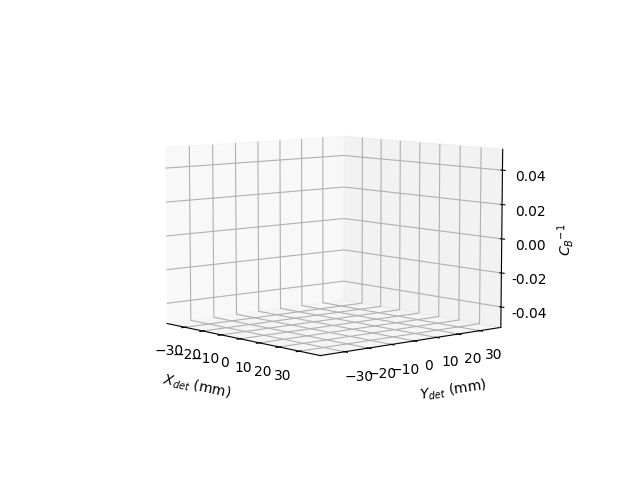

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Given data
x = np.array([-18.122448921203613, -10.285714864730835, -0.4571428522467613, 10.644898414611816, 19.918367862701416, 27.885713577270508, -20.342857837677002, -11.167347431182861, -0.48979591578245163, 10.089795589447021, 20.865306854248047, 30.432653427124023, -21.910204887390137, -11.23265266418457, -0.3591836616396904, 10.351020097732544, 20.865306854248047, 31.80408239364624, -21.844897270202637, -11.004081964492798, -0.09795918129384518, 10.122449398040771, 21.028571128845215, 31.379592418670654, -20.897958278656006, -11.26530647277832, -0.19591836258769035, 10.31836748123169, 21.812245845794678, 30.138776302337646, -17.828571796417236, -10.710203647613525, -0.5877551063895226, 10.840816497802734, 19.199999570846558, 27.85306215286255])
y = np.array([-20.114285945892334, -22.302041053771973, -24.130611419677734, -23.51020336151123, -22.43265390396118, -19.95102047920227, -12.506122589111328, -13.942856788635254, -14.171428680419922, -13.257142305374146, -13.551020622253418, -11.983673572540283, -2.6775509119033813, -2.8081631660461426, -2.220408171415329, -2.742857038974762, -2.35102042555809, -2.3836734890937805, 8.359183669090271, 8.13061237335205, 7.967346906661987, 8.261224627494812, 8.326530456542969, 8.293877840042114, 17.27346897125244, 18.971428871154785, 18.677550554275513, 19.00408148765564, 19.13469433784485, 18.253061771392822, 26.253061294555664, 28.048980236053467, 29.159183502197266, 29.159183502197266, 27.75510311126709, 25.73061227798462])
dld_t = np.array([1.011774301065406, 1.0053236457982464, 1.000903707710839, 1.0008608589381898, 1.0065498165730615, 1.0131405556076538, 1.0097022103429871, 0.9970961238956674, 0.9893884133044435, 0.9889955482221412, 0.9974707118164278, 1.0106836966849873, 1.0094256130697952, 0.993324673078915, 0.984746337701787, 0.9847964475123426, 0.9932437898421668, 1.0094017665789154, 1.013966824746841, 0.9973463136347074, 0.9889244843577426, 0.9890051005499628, 0.9970482980825784, 1.0125722834217321, 1.0218259384395652, 1.0099513962565199, 1.0012092766530518, 1.00102513238016, 1.0093261279227062, 1.0204655955468225, 1.0307618632576618, 1.0257911385699645, 1.0202179770154478, 1.0198319387163561, 1.0227124863326351, 1.0277846318133985])

# Define the hemisphere function
def hemisphere(coords, cx, cy, r, c0):
    x, y = coords
    return c0 * np.sqrt(np.maximum(0, r**2 - (x - cx)**2 - (y - cy)**2))

bounds = ([-np.inf, -np.inf, 0, -np.inf], [np.inf, np.inf, np.inf, np.inf])

# Fit the hemisphere function to the data
popt, pcov = curve_fit(hemisphere, [np.array(x), np.array(y)],
                                    np.array(dld_t), p0=(0, 0, 1, 0.1), bounds=bounds)

# Extract the optimized parameters
cx, cy, r, c0 = popt
print(cx, cy, r, c0)

model_x_data = np.linspace(-35, 35, 30)
model_y_data = np.linspace(-35, 35, 30)
X, Y = np.meshgrid(model_x_data, model_y_data)
Z = hemisphere(np.array([X, Y]), *popt)

fig, ax = plt.subplots(subplot_kw=dict(projection="3d"))
fig.add_axes(ax)
ax.plot_surface(X, Y, 1 / Z)
ax.set_xlabel(r'$X_{det}$ (mm)', fontsize=10, labelpad=10)
ax.set_ylabel(r'$Y_{det}$ (mm)', fontsize=10, labelpad=10)
ax.set_zlabel(r"${C_B}^{-1}$", fontsize=10, labelpad=5)
ax.zaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
ax.view_init(elev=7, azim=-41)
plt.show()



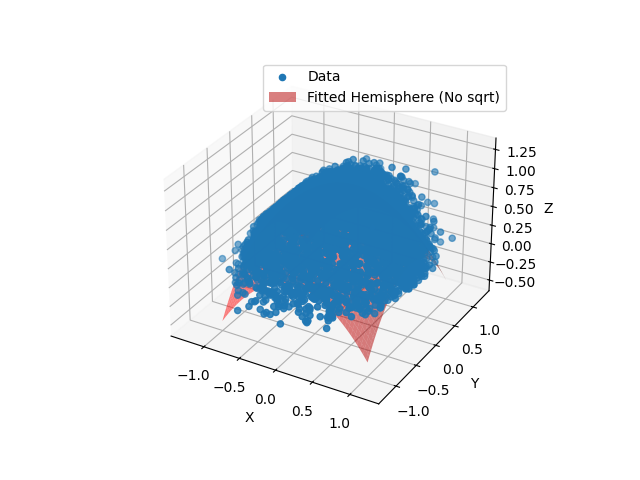

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Function for a hemisphere without square root
def hemisphere_fit(xy, a, b, c, r):
    x, y = xy
    z = a * (x - b)**2 + c * (y - b)**2 + r**2
    return z

# Generate some sample data for a hemisphere
np.random.seed(0)
theta = np.linspace(0, 2 * np.pi, 100)
phi = np.linspace(0, np.pi / 2, 50)
theta, phi = np.meshgrid(theta, phi)
x = np.sin(phi) * np.cos(theta)
y = np.sin(phi) * np.sin(theta)
z = np.cos(phi)
noise = 0.1 * np.random.normal(size=x.shape)
x += noise
y += noise
z += noise

# Flatten the data
x_data = x.flatten()
y_data = y.flatten()
z_data = z.flatten()

# Initial guess for the parameters (a, b, c, r)
initial_guess = [1.0, 0.0, 1.0, 1.0]

# Fit the data to the hemisphere function without square root
params, covariance = curve_fit(hemisphere_fit, (x_data, y_data), z_data, bounds=(-np.inf, np.inf), p0=initial_guess, maxfev=2000)

# Plot the original data and the fitted hemisphere
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_data, y_data, z_data, label='Data')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Create a meshgrid for the fitted hemisphere
fit_x, fit_y = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
fit_z = hemisphere_fit((fit_x, fit_y), *params)

# Plot the fitted hemisphere without square root
ax.plot_surface(fit_x, fit_y, fit_z, alpha=0.5, color='r', label='Fitted Hemisphere (No sqrt)')

plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.optimize import minimize

# Generate synthetic 2D data on a hemisphere
# theta = np.linspace(0, np.pi, 100)
# phi = np.linspace(0, 2 * np.pi, 100)
# theta, phi = np.meshgrid(theta, phi)
# r = 1  # Radius of the hemisphere
# x_true = r * np.sin(theta) * np.cos(phi)
# y_true = r * np.sin(theta) * np.sin(phi)
# z_true = r * np.cos(theta)

x = np.array([-18.122448921203613, -10.285714864730835, -0.4571428522467613, 10.644898414611816, 19.918367862701416, 27.885713577270508, -20.342857837677002, -11.167347431182861, -0.48979591578245163, 10.089795589447021, 20.865306854248047, 30.432653427124023, -21.910204887390137, -11.23265266418457, -0.3591836616396904, 10.351020097732544, 20.865306854248047, 31.80408239364624, -21.844897270202637, -11.004081964492798, -0.09795918129384518, 10.122449398040771, 21.028571128845215, 31.379592418670654, -20.897958278656006, -11.26530647277832, -0.19591836258769035, 10.31836748123169, 21.812245845794678, 30.138776302337646, -17.828571796417236, -10.710203647613525, -0.5877551063895226, 10.840816497802734, 19.199999570846558, 27.85306215286255])
y = np.array([-20.114285945892334, -22.302041053771973, -24.130611419677734, -23.51020336151123, -22.43265390396118, -19.95102047920227, -12.506122589111328, -13.942856788635254, -14.171428680419922, -13.257142305374146, -13.551020622253418, -11.983673572540283, -2.6775509119033813, -2.8081631660461426, -2.220408171415329, -2.742857038974762, -2.35102042555809, -2.3836734890937805, 8.359183669090271, 8.13061237335205, 7.967346906661987, 8.261224627494812, 8.326530456542969, 8.293877840042114, 17.27346897125244, 18.971428871154785, 18.677550554275513, 19.00408148765564, 19.13469433784485, 18.253061771392822, 26.253061294555664, 28.048980236053467, 29.159183502197266, 29.159183502197266, 27.75510311126709, 25.73061227798462])
dld_t = np.array([1.011774301065406, 1.0053236457982464, 1.000903707710839, 1.0008608589381898, 1.0065498165730615, 1.0131405556076538, 1.0097022103429871, 0.9970961238956674, 0.9893884133044435, 0.9889955482221412, 0.9974707118164278, 1.0106836966849873, 1.0094256130697952, 0.993324673078915, 0.984746337701787, 0.9847964475123426, 0.9932437898421668, 1.0094017665789154, 1.013966824746841, 0.9973463136347074, 0.9889244843577426, 0.9890051005499628, 0.9970482980825784, 1.0125722834217321, 1.0218259384395652, 1.0099513962565199, 1.0012092766530518, 1.00102513238016, 1.0093261279227062, 1.0204655955468225, 1.0307618632576618, 1.0257911385699645, 1.0202179770154478, 1.0198319387163561, 1.0227124863326351, 1.0277846318133985])

# Add some noise to the data
# noise = 0.1 * np.random.normal(size=x_true.shape)
# x_data = x_true + noise
# y_data = y_true + noise

# Define the objective function
def objective(params, x, y):
    cx, cy, r = params
    distance = np.sqrt((x - cx)**2 + (y - cy)**2)
    residuals = distance - np.sqrt(r**2 - distance**2)
    return np.sum(residuals**2)

# Define the calibration factor function
def f_bowl(x, y, params):
    cx, cy, r = params
    distance = np.sqrt((x - cx)**2 + (y - cy)**2)
    f_bowl = np.sqrt(r**2 - distance**2) / r
    return f_bowl

# Initial guess and optimization
initial_guess = [0.1, 0.1, 1]  # Initial guess for center (cx, cy) and radius r
result = minimize(objective, initial_guess, args=(x_data.flatten(), y_data.flatten()), method='Powell')
cx, cy, r = result.x
print(cx, cy, r)

# Calculate the calibration factor for each point on the surface
f_bowl_values = f_bowl(x_data, y_data, result.x)

print(f_bowl_values)
# Plot the fitted hemisphere
fig = plt.figure(figsize=(10, 6))

# Plot the fitted hemisphere surface
# ax1 = fig.add_subplot(121, projection='3d')
# ax1.plot_surface(x_data, y_data, np.sqrt(r**2 - x_data**2 - y_data**2), alpha=0.5, color='blue')
# ax1.set_title('Fitted Hemisphere')

# Plot the calibration factor as a function of x and y
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(x_data.reshape(x_data.shape[0], -1), y_data.reshape(y_data.shape[0], -1), f_bowl_values.reshape(f_bowl_values.shape[0], -1), cmap='viridis', alpha=0.8)
ax2.set_title('Calibration Factor (f_bowl)')

plt.show()


In [ ]:
from pymatgen.io.cif import CifParser
from pymatgen.core.structure import Structure

# Replace 'your_file.cif' with the actual path to your CIF file
cif_file_path = 'Al.cif'

# Parse the CIF file
parser = CifParser(cif_file_path)
structure = parser.get_structures()[0]

print(structure)
# Make a supercell
structure.make_supercell([6, 6, 6])

# Get atomic positions
positions = structure.as_dataframe()

x_positions = positions['x']
y_positions = positions['y']
z_positions = positions['z']
# Plot the expanded structure using Matplotlib
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')



# Plot atomic positions
ax.scatter(x_positions, y_positions, z_positions, c='b', marker='o', s=100)

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()


In [ ]:
# Replace 'your_file.xyz' with the actual path to your XYZ file
file_path = 'Al_big.xyz'

# Read the XYZ file
with open(file_path, 'r') as file:
    lines = file.readlines()

# Extract the number of atoms
num_atoms = int(lines[0])

# Initialize arrays to store x, y, and z coordinates
x_positions = np.zeros(num_atoms)
y_positions = np.zeros(num_atoms)
z_positions = np.zeros(num_atoms)

# Loop through lines starting from the second line (skipping the number of atoms line)
for i, line in enumerate(lines[2:]):
    parts = line.split()
    x_positions[i] = float(parts[1])
    y_positions[i] = float(parts[2])
    z_positions[i] = float(parts[3])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x_positions, y_positions, z_positions, s=50, c='b', marker='o', edgecolors='k')

ax.set_xlabel('X (Å)')
ax.set_ylabel('Y (Å)')
ax.set_zlabel('Z (Å)')
ax.set_title('Atomic Structure')

plt.show()

# Define the center and radius of the half sphere
sphere_center = np.array([x_positions.mean(), y_positions.mean(), z_positions.mean()])
sphere_radius = 10.0  # Adjust the radius as needed

# Create a boolean mask to filter atoms outside the half sphere
distance_from_center = np.linalg.norm(np.column_stack((x_positions, y_positions, z_positions)) - sphere_center, axis=1)
atoms_in_half_sphere = distance_from_center <= sphere_radius

# Apply the mask to filter out atoms outside the half sphere
x_positions_half_sphere = x_positions[atoms_in_half_sphere]
y_positions_half_sphere = y_positions[atoms_in_half_sphere]
z_positions_half_sphere = z_positions[atoms_in_half_sphere]

# Plot the remaining atoms in the half sphere
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x_positions_half_sphere, y_positions_half_sphere, z_positions_half_sphere, s=50, c='b', marker='o', edgecolors='k')

ax.set_xlabel('X (Å)')
ax.set_ylabel('Y (Å)')
ax.set_zlabel('Z (Å)')
ax.set_title('Atomic Structure - Half Sphere')

plt.show()

sample_2d_histogram(x_positions_half_sphere, z_positions_half_sphere, bins=(512, 512), xlabel='x (nm)', ylabel='z (nm)')

In [ ]:
from ase.build import bulk
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize

####################
# # Create the aluminum bulk crystal structure
# aluminum = bulk('Al', 'fcc', a=4.49580, b=4.49580, c=8.99160, alpha=90.0,  cubic=True)

# # Replicate the unit cell in x, y, and z directions to create a larger volume
# aluminum = aluminum.repeat((10, 10, 20))

# # Get the atomic positions
# positions = aluminum.get_positions()

# # Extract x, y, z coordinates from the positions
# x, y, z = positions[:, 0], positions[:, 1], positions[:, 2]

#################
# Create a small unit cell of aluminum
aluminum_unit_cell = bulk('Al', 'fcc', a=4.49580, b=4.49580, c=8.99160, alpha=90.0,  cubic=True)
view(aluminum_unit_cell, viewer='x3d', show_unit_cell=True)

# Calculate the dimensions of the supercell
supercell_dimensions = (5, 5, 10)
cell_parameters = cell_to_cellpar(aluminum_unit_cell.cell)
supercell_parameters = [dim * param for dim, param in zip(supercell_dimensions, cell_parameters)]

# Create a supercell
aluminum = Atoms(cell=supercell_parameters)
aluminum.extend(aluminum_unit_cell.repeat(supercell_dimensions))


# Get atomic positions
positions = aluminum.get_positions()

# Separate x, y, and z coordinates into arrays
x = positions[:, 0]
y = positions[:, 1]
z = positions[:, 2]
######################


# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='b', marker='o', s=20, label='Aluminum Atoms')

# Set labels
ax.set_xlabel('X (Å)')
ax.set_ylabel('Y (Å)')
ax.set_zlabel('Z (Å)')
ax.set_title('3D Crystal Structure of Aluminum')

# Show the plot
plt.show()



In [ ]:
# Function to calculate 3D FFT and plot the result
def calculate_3d_fft_and_plot(x, y, z):
    # Combine x, y, z coordinates into a complex 3D array
    data = x + 1j * y + 1j**2 * z

    # Perform 3D FFT
    fft_result = np.fft.fftn(data)

    # Get the magnitudes of the FFT result
    fft_magnitude = np.abs(fft_result)

    # Plot the 3D FFT magnitudes
    fig_fft = plt.figure()
    ax_fft = fig_fft.add_subplot(111, projection='3d')
    
    # Get the coordinates of non-zero values in fft_magnitude
    nonzero_coords = np.where(fft_magnitude > 1e-3)
    
    # Scatter plot with x, y, z coordinates
    ax_fft.scatter(nonzero_coords[0], nonzero_coords[1], nonzero_coords[2], c='r', marker='o', s=20, label='FFT Peaks')
    ax_fft.set_xlabel('Frequency X (1/Å)')
    ax_fft.set_ylabel('Frequency Y (1/Å)')
    ax_fft.set_zlabel('Frequency Z (1/Å)')
    ax_fft.set_title('3D FFT of Crystal Structure')

    plt.show()

# Calculate 3D FFT for x, y, and z coordinates
calculate_3d_fft_and_plot(x, y, z)